# Deep Convolutional GAN
## Dipack P Panjabi, 50291077, dipackpr@buffalo.edu
4 Convolutional layers, 64 filters multiplier for both generator and discriminator, batch-size 32 images (due to GPU VRAM constraints), 10 epochs (each using the entire CIFAR-10 dataset)

In [1]:
%matplotlib inline
import os
import shutil
import logging
import torch as t
import torch.nn as tnn
import torch.optim as toptimizer
import torch.backends.cudnn as tcudnn
import torchvision.utils as tutils
from modules import FID
from util import setup_argparser, get_dataset, init_layer_weights, plot_losses, plot_fid_scores, save_best_generator_image, mean_fid, clean_make_dir

logging.basicConfig(format='%(asctime)s - %(levelname)s: %(message)s', datefmt='%d/%m/%Y %I:%M:%S %p',
                    level=logging.INFO)

In [2]:
class DCGenerator(tnn.Module):
    def __init__(self, latent_size=100, hidden_units=64):
        super(DCGenerator, self).__init__()
        self.l1 = tnn.Sequential(
            # Input layer
            tnn.ConvTranspose2d(latent_size, out_channels=hidden_units * 8, kernel_size=4, stride=1, padding=0, bias=False),
            tnn.BatchNorm2d(hidden_units * 8),
            tnn.ReLU(True)
                )
        self.l2 = tnn.Sequential(
            # Layer 2
            tnn.ConvTranspose2d(hidden_units * 8, hidden_units * 4, 4, 2, 1, bias=False),
            tnn.BatchNorm2d(hidden_units * 4),
            tnn.ReLU(True)
                )
        self.l3 = tnn.Sequential(
            # Layer 3
            tnn.ConvTranspose2d(hidden_units * 4, hidden_units * 2, 4, 2, 1, bias=False),
            tnn.BatchNorm2d(hidden_units * 2),
            tnn.ReLU(True)
                )
        self.l4 = tnn.Sequential(
            # Layer 4
            tnn.ConvTranspose2d(hidden_units * 2, hidden_units, 4, 2, 1, bias=False),
            tnn.BatchNorm2d(hidden_units),
            tnn.ReLU(True)
                )
        self.lout = tnn.Sequential(
            # Output Layer
            # CIFAR-10 reps RGB images, so there are 3 channels in the output
            # Changes made to the final layer to work with 32 * 32
            tnn.ConvTranspose2d(hidden_units, out_channels=3, kernel_size=1, stride=1, padding=0, bias=False),
            tnn.Tanh()
                )
        return

    def forward(self, x):
        output = self.l1(x)
        output = self.l2(output)
        output = self.l3(output)
        output = self.l4(output)
        output = self.lout(output)
        return output

class DCDiscriminator(tnn.Module):
    def __init__(self, hidden_units=64):
        super(DCDiscriminator, self).__init__()
        self.l1 = tnn.Sequential(
                # Input layer
                tnn.Conv2d(in_channels=3, out_channels=hidden_units, kernel_size=4, stride=2, padding=1, bias=False),
                tnn.LeakyReLU(0.2, inplace=True)
                )
        self.l2 = tnn.Sequential(
                # Layer 1
                tnn.Conv2d(hidden_units, hidden_units * 2, 4, 2, 1, bias=False),
                tnn.BatchNorm2d(hidden_units * 2),
                tnn.LeakyReLU(0.2, inplace=True)
                )
        self.l3 = tnn.Sequential(
                # Layer 2
                tnn.Conv2d(hidden_units * 2, hidden_units * 4, 4, 2, 1, bias=False),
                tnn.BatchNorm2d(hidden_units * 4),
                tnn.LeakyReLU(0.2, inplace=True)
                )
        self.l4 = tnn.Sequential(
                # Layer 3
                tnn.Conv2d(hidden_units * 4, hidden_units * 8, 4, 2, 1, bias=False),
                tnn.BatchNorm2d(hidden_units * 8),
                tnn.LeakyReLU(0.2, inplace=True)
                )
        self.lout = tnn.Sequential(
                # Output Layer
                # Changes made to the final layer to work with 32 * 32
                tnn.Conv2d(hidden_units * 8, 1, 2, 2, 0, bias=False),
                tnn.Sigmoid()
                )
        return

    def forward(self, x):
        output = self.l1(x)
        output = self.l2(output)
        output = self.l3(output)
        output = self.l4(output)
        output = self.lout(output)
        return output.view(-1, 1).squeeze(1)

### Parameters

In [3]:
path             = "./cifar10"
output_path      = "./output/dcgan"
learning_rate    = 0.0002
batch_size       = 32
latent_size      = 100
num_epochs       = 15
gen_hidden_units = 64
dis_hidden_units = 64
debug_info       = False
clean_dirs       = True
save_best        = True
log_interval     = 100
fid_batch_interval = 10

### Actual model run

19/10/2019 11:32:31 PM - INFO: Clean selected - removing: ./output/dcgan
19/10/2019 11:32:31 PM - INFO: Creating output directory: ./output/dcgan
19/10/2019 11:32:31 PM - INFO: Dataset path: ./cifar10, Output path: ./output/dcgan, Batch Size: 32, Latent Size: 100, Num iterations: 15, Generator unit multiplier: 64, Discriminator unit multiplier: 64, Learning rate: 0.0002


Files already downloaded and verified
Files already downloaded and verified


19/10/2019 11:32:33 PM - INFO: CUDA enabled device found - will use CUDA device
19/10/2019 11:32:39 PM - INFO: DCGenerator(
  (l1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

19/10/2019 11:47:38 PM - INFO: Epoch: 4/15, Sample: 1101/1562, Disc Loss: 0.8487, Gen Loss: 1.9487
19/10/2019 11:47:46 PM - INFO: Epoch: 4/15, Sample: 1201/1562, Disc Loss: 1.7484, Gen Loss: 0.5090
19/10/2019 11:47:55 PM - INFO: Epoch: 4/15, Sample: 1301/1562, Disc Loss: 1.1177, Gen Loss: 1.5951
19/10/2019 11:48:03 PM - INFO: Epoch: 4/15, Sample: 1401/1562, Disc Loss: 0.8453, Gen Loss: 1.4718
19/10/2019 11:48:11 PM - INFO: Epoch: 4/15, Sample: 1501/1562, Disc Loss: 1.1206, Gen Loss: 1.5611
19/10/2019 11:49:58 PM - INFO: Epoch 4 FID score: 60.21502952192297
19/10/2019 11:49:58 PM - INFO: Epoch: 5/15, Sample: 1/1562, Disc Loss: 0.8642, Gen Loss: 1.8181
19/10/2019 11:50:11 PM - INFO: Epoch: 5/15, Sample: 101/1562, Disc Loss: 1.4535, Gen Loss: 1.3702
19/10/2019 11:50:24 PM - INFO: Epoch: 5/15, Sample: 201/1562, Disc Loss: 1.0848, Gen Loss: 1.4674
19/10/2019 11:50:36 PM - INFO: Epoch: 5/15, Sample: 301/1562, Disc Loss: 0.9695, Gen Loss: 1.1427
19/10/2019 11:50:49 PM - INFO: Epoch: 5/15, Sam

20/10/2019 12:09:20 AM - INFO: Epoch: 9/15, Sample: 1101/1562, Disc Loss: 0.7123, Gen Loss: 2.3923
20/10/2019 12:09:33 AM - INFO: Epoch: 9/15, Sample: 1201/1562, Disc Loss: 1.3551, Gen Loss: 1.5252
20/10/2019 12:09:46 AM - INFO: Epoch: 9/15, Sample: 1301/1562, Disc Loss: 1.0187, Gen Loss: 2.0427
20/10/2019 12:09:59 AM - INFO: Epoch: 9/15, Sample: 1401/1562, Disc Loss: 0.3598, Gen Loss: 3.6603
20/10/2019 12:10:12 AM - INFO: Epoch: 9/15, Sample: 1501/1562, Disc Loss: 0.7149, Gen Loss: 1.6850
20/10/2019 12:12:02 AM - INFO: Epoch 9 FID score: 41.64867776527453
20/10/2019 12:12:02 AM - INFO: Epoch: 10/15, Sample: 1/1562, Disc Loss: 0.4503, Gen Loss: 3.8948
20/10/2019 12:12:11 AM - INFO: Epoch: 10/15, Sample: 101/1562, Disc Loss: 0.9821, Gen Loss: 2.9308
20/10/2019 12:12:19 AM - INFO: Epoch: 10/15, Sample: 201/1562, Disc Loss: 1.1187, Gen Loss: 2.1479
20/10/2019 12:12:28 AM - INFO: Epoch: 10/15, Sample: 301/1562, Disc Loss: 0.3451, Gen Loss: 3.3030
20/10/2019 12:12:36 AM - INFO: Epoch: 10/15

20/10/2019 12:31:17 AM - INFO: Epoch: 14/15, Sample: 1101/1562, Disc Loss: 0.7903, Gen Loss: 2.3880
20/10/2019 12:31:26 AM - INFO: Epoch: 14/15, Sample: 1201/1562, Disc Loss: 0.9609, Gen Loss: 1.7779
20/10/2019 12:31:34 AM - INFO: Epoch: 14/15, Sample: 1301/1562, Disc Loss: 0.2793, Gen Loss: 4.6563
20/10/2019 12:31:42 AM - INFO: Epoch: 14/15, Sample: 1401/1562, Disc Loss: 0.0339, Gen Loss: 3.5793
20/10/2019 12:31:51 AM - INFO: Epoch: 14/15, Sample: 1501/1562, Disc Loss: 0.1295, Gen Loss: 3.9955
20/10/2019 12:34:02 AM - INFO: Epoch 14 FID score: 38.78778970042504
20/10/2019 12:34:02 AM - INFO: Epoch: 15/15, Sample: 1/1562, Disc Loss: 0.1606, Gen Loss: 3.5468
20/10/2019 12:34:12 AM - INFO: Epoch: 15/15, Sample: 101/1562, Disc Loss: 0.0554, Gen Loss: 4.4879
20/10/2019 12:34:18 AM - INFO: Epoch: 15/15, Sample: 201/1562, Disc Loss: 0.8323, Gen Loss: 4.6264
20/10/2019 12:34:27 AM - INFO: Epoch: 15/15, Sample: 301/1562, Disc Loss: 0.5989, Gen Loss: 4.0626
20/10/2019 12:34:35 AM - INFO: Epoch:

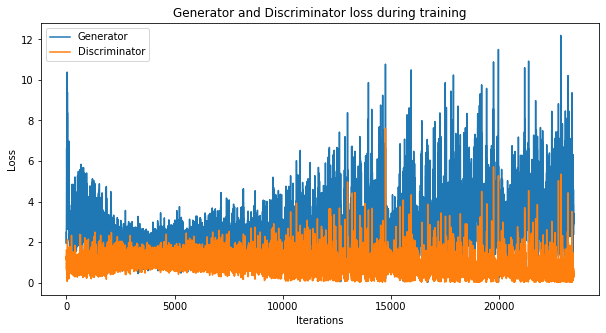

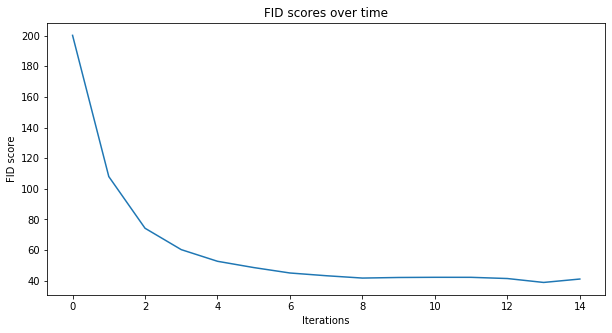

20/10/2019 12:38:24 AM - INFO: Generator model with lowest FID score is ./output/dcgan/generator_epoch_14.pth
20/10/2019 12:38:24 AM - INFO: Saving output of best generator model to ./output/dcgan/best_fake_sample.png


In [4]:
if clean_dirs:
    clean_make_dir(output_path)

logging.info("Dataset path: {}, Output path: {}, Batch Size: {}, Latent Size: {}, Num iterations: {}, Generator unit multiplier: {}, Discriminator unit multiplier: {}, Learning rate: {}".format(path, output_path, batch_size, latent_size, num_epochs, gen_hidden_units, dis_hidden_units, learning_rate))

training_dataset = get_dataset(path, train=True)
# Dropping the last batch as it is sometimes not divisible by batch_size,
# causing errors when trying to feed it to the GAN.
training_data_loader = t.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
testing_dataset_path = "{0}/test".format(path)
testing_dataset = get_dataset(testing_dataset_path, train=False)
testing_data_loader = t.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
testing_data_iter = iter(testing_data_loader)

device = t.device("cpu")
if t.cuda.is_available():
    logging.info("CUDA enabled device found - will use CUDA device")
    device = t.device("cuda:0")

# Init FID calculator
fid_calculator = FID(device=device)

gen_weights = None
generator = DCGenerator(latent_size=latent_size, hidden_units=gen_hidden_units).to(device)
generator.apply(init_layer_weights)
if gen_weights is not None:
    logging.info("Using weights saved at {} to continue Generator training".format(gen_weights))
    generator.load_state_dict(t.load(gen_weights))

dis_weights = None
discriminator = DCDiscriminator(hidden_units=dis_hidden_units).to(device)
discriminator.apply(init_layer_weights)
if dis_weights is not None:
    logging.info("Using weights saved at {} to continue Discriminator training".format(dis_weights))
    discriminator.load_state_dict(t.load(dis_weights))

logging.info(generator)
logging.info(discriminator)

loss = tnn.BCELoss()
noise = t.randn(batch_size, latent_size, 1, 1, device=device)

REAL_IMAGE_BEACON = 1
FAKE_IMAGE_BEACON = 0

dis_optimizer = toptimizer.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
gen_optimizer = toptimizer.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

gen_filenames = []
gen_losses = []
dis_losses = []
fid_scores = []

# START - Training epoch loop
for epoch in range(num_epochs):
    # Variables to hold generated and fake images for FID score calc
    real_image_batch, fake_image_batch = None, None
    # START - Training batch loop
    for idx, data in enumerate(training_data_loader, start=0):
        # Train discriminator network
        discriminator.zero_grad()
        # Real data
        real_images = data[0].to(device)
        # Batch size
        bs = real_images.size(0)
        label = t.full((bs,), REAL_IMAGE_BEACON, device=device)

        output = discriminator(real_images)
        dis_err_real = loss(output, label)
        # Propagate error gradient backwards
        dis_err_real.backward()
        # Discriminator output mean for real images
        D_x = output.mean().item()

        # Train with fake data
        epoch_noise = t.randn(batch_size, latent_size, 1, 1, device=device)
        # Generate fake images using noise
        fake_images = generator(epoch_noise)
        label.fill_(FAKE_IMAGE_BEACON)
        # Discriminator output for fake images
        output = discriminator(fake_images.detach())
        dis_err_fake = loss(output, label)
        # Propagate error gradient for discriminator backwards - on fake images
        dis_err_fake.backward()
        # Discriminator output mean for fake images - before discriminator update
        D_G_z1 = output.mean().item()
        dis_err = dis_err_real + dis_err_fake
        dis_optimizer.step()

        # Train generator network
        generator.zero_grad()
        label.fill_(REAL_IMAGE_BEACON)
        # Test discriminator again - this time after training it
        output = discriminator(fake_images)
        gen_err = loss(output, label)
        gen_err.backward()
        # Discriminator output mean for fake images - after discriminator update
        D_G_z2 = output.mean().item()
        gen_optimizer.step()

        gen_losses.append(gen_err.item())
        dis_losses.append(dis_err.item())

        if idx % log_interval == 0:
            log_info = "Epoch: {}/{}, Sample: {}/{}, Disc Loss: {:.4f}, Gen Loss: {:.4f}".format(epoch + 1, num_epochs, idx + 1, len(training_data_loader), dis_err.item(), gen_err.item())
            if debug_info:
                log_info += ", D(x): {:.4f}, D(G(z)): {:.4f} / {:.4f}".format(D_x, D_G_z1, D_G_z2)
            logging.info(log_info)

        if idx % 100 == 0 or idx == (len(training_data_loader) - 1):
            tutils.save_image(real_images, "{0}/real_samples.png".format(output_path), normalize=True)
            fake_images = generator(noise)
            tutils.save_image(fake_images.detach(), "{0}/fake_samples_epoch_{1}.png".format(output_path, epoch + 1), normalize=True)
            
        if idx % fid_batch_interval == 0:
            # Add to fake image batch for FID score calc
            if fake_image_batch is None:
                fake_image_batch = fake_images.detach()
            else:
                fake_image_batch = t.cat((fake_image_batch, fake_images.detach()), dim=0)
    # END - Training batch loop

    g_weight_filename = "{0}/generator_epoch_{1}.pth".format(output_path, epoch + 1)
    gen_filenames.append(g_weight_filename)
    # Checkpoint model
    t.save(generator.state_dict(), g_weight_filename)
    t.save(discriminator.state_dict(), "{0}/discriminator_epoch_{1}.pth".format(output_path, epoch + 1))

    # Calculate FID scores after each epoch - as it is super slow during normal iterations
    while real_image_batch is None or len(real_image_batch) < len(fake_image_batch):
        try:
            r_im, _ = next(testing_data_iter)
            r_im.to(device=device)
            if real_image_batch is None:
                real_image_batch = r_im
            else:
                real_image_batch = t.cat((real_image_batch, r_im), dim=0)
        except StopIteration:
            testing_data_iter = iter(testing_data_loader)
    fid_score = fid_calculator.calculate_fid(real_image_batch, fake_image_batch, batch_size)
    fid_scores.append(fid_score)
    logging.info("Epoch {} FID score: {}".format(epoch + 1, fid_score))
# END - Training epoch loop

logging.info("FID scores over the epochs: {}".format(fid_scores))
logging.info("Mean FID score: {}".format(mean_fid(fid_scores)))
plot_losses(gen_losses, dis_losses)
plot_fid_scores(fid_scores)

# Output from generator model with lowest FID score
if save_best:
    save_best_generator_image(generator, gen_filenames, fid_scores, noise, output_path)


20/10/2019 12:38:24 AM - INFO: Last image generated


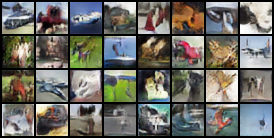

20/10/2019 12:38:24 AM - INFO: Image generated from model with lowest FID score


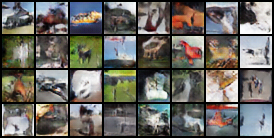

In [5]:
from IPython.display import Image, display

logging.info("Last image generated")
display(Image(filename="{0}/fake_samples_epoch_{1}.png".format(output_path, num_epochs)))
if save_best:
    logging.info("Image generated from model with lowest FID score")
    display(Image(filename="{0}/best_fake_sample.png".format(output_path)))